<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/XGBoost_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Modelling Baseline
- **참고**

https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv', sep='\t')

In [24]:
data.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT
0,20190201,110,517,10,F,25,11,595
1,20190201,110,517,10,F,50,5,243
2,20190201,110,517,10,F,55,5,27
3,20190201,110,517,10,M,20,11,243
4,20190201,110,517,10,M,25,11,433


# Seoul 2019 / 2020
- 서울 중구, 서울 노원구: 구코드 140, 350

In [4]:
seoul = pd.concat([data[data.GU_CD == 140], data[data.GU_CD == 350]]).reset_index().drop('index', axis=1)
seoul.STD_DD = seoul.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
seoul.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT
0,2019-02-01,140,520,10,F,20,14,1038
1,2019-02-01,140,520,10,F,25,59,4635
2,2019-02-01,140,520,10,F,30,41,3046
3,2019-02-01,140,520,10,F,35,59,5995
4,2019-02-01,140,520,10,F,40,45,5172


In [5]:
df2019 = seoul[seoul.STD_DD < '2020-01-01']
df2020 = seoul[seoul.STD_DD > '2020-01-01']

# Train / Val / Test split
- 2020년 데이터만을 활용
- validation set: 5월 1~3 주
- test set: 5월 마지막 주

In [195]:
df = pd.DataFrame(df2020.groupby('STD_DD')['USE_AMT'].sum())

In [196]:
split_date = '2020-05-03'
split_date2 = '2020-05-25'

df_train = pd.DataFrame(df[df.index <= split_date])
df_ = pd.DataFrame(df[df.index > split_date]) # test + val
df_val = pd.DataFrame(df_[df_.index <= split_date2])
df_test = pd.DataFrame(df_[df_.index > split_date2])

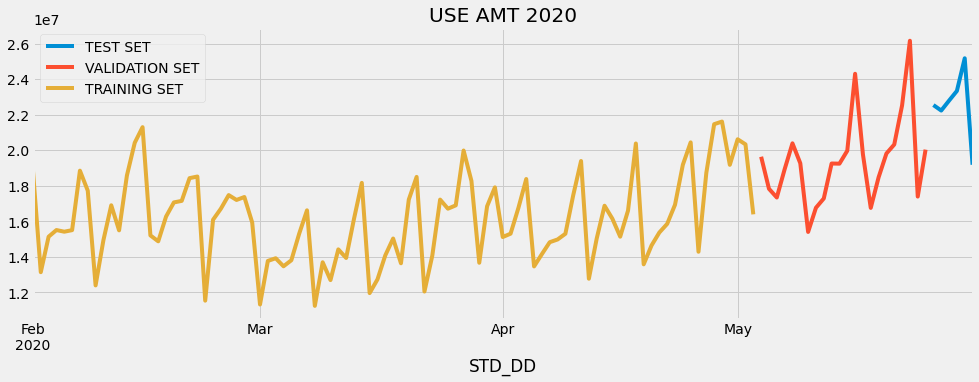

In [197]:
# Train, Validation, Test 구분
_ = df_test \
    .rename(columns={'USE_AMT': 'TEST SET'}) \
    .join(df_val.rename(columns={'USE_AMT': 'VALIDATION SET'}), how='outer') \
    .join(df_train.rename(columns={'USE_AMT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='USE AMT 2020')

In [6]:
def create_features(df, label=None, date=False):

    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    # df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    # df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if date == True:
        X = df[['dayofweek','month', # ,'quarter'
            'dayofyear','dayofmonth','weekofyear'
            ,'date']]
    else:
        X = df[['dayofweek','month', # ,'quarter'
            'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]
        return X, y

    return X

In [199]:
# X: 시간에 대한 정보, y: 소비량
X_train, y_train = create_features(df_train, label='USE_AMT')
X_test, y_test = create_features(df_val, label='USE_AMT')

# XGBoost Model

In [200]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[10:53:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# Feature Importances

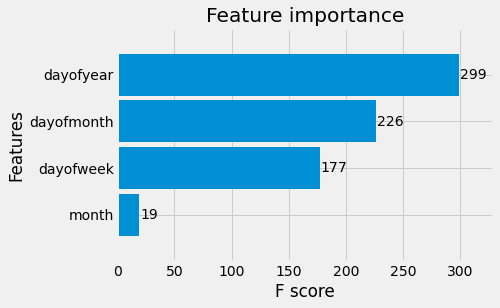

In [61]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [201]:
# 실제 test
X, y = create_features(df_test, label='USE_AMT')
pred = reg.predict(X)

In [202]:
# val, test 각각의 예측값 시각화를 위한 데이터 생성
df_['AMT_Prediction'] = list(reg.predict(X_test)) + list(pred)
df_val_ = df_[df_.index <= split_date2].drop('USE_AMT', axis=1)
df_test_ = df_[df_.index > split_date2].drop('USE_AMT', axis=1)\
            .rename(columns={'AMT_Prediction': 'AMT_Prediction_Final'})
df_ = df[['USE_AMT']]

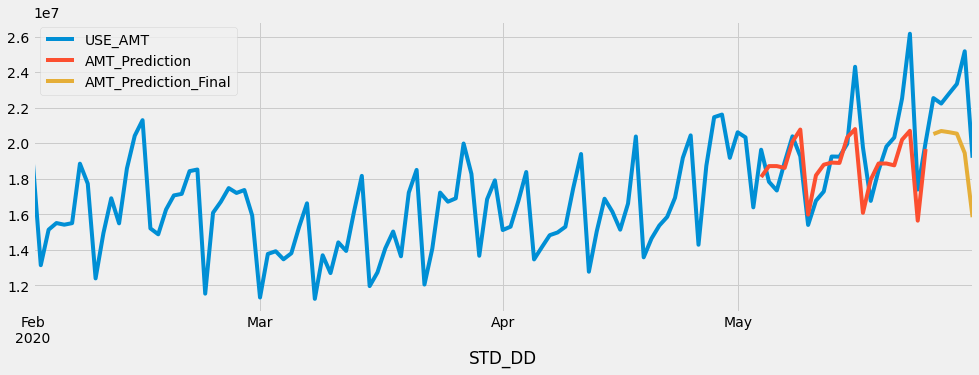

In [203]:
# 예측 결과
df_all = df_.join(df_val_, how='left').join(df_test_, how='left')
_ = df_all.plot(figsize=(15, 5))

In [60]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    print(round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2), '%')

mean_absolute_percentage_error(y_true=y, y_pred=reg.predict(x))

# Improving Model
### 1. USE_CNT Feature 추가
성능이 굉장히 올라간다. 그리고 XGBoost 모델은 트리 기반이기 때문에 스케일링 할 필요가 없다.

In [108]:
# USE_CNT 추가
df = df2020.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()

split_date = '2020-05-03'
split_date2 = '2020-05-25'

df_train = pd.DataFrame(df[df.index <= split_date])
df_ = pd.DataFrame(df[df.index > split_date]) # test + val
df_val = pd.DataFrame(df_[df_.index <= split_date2])
df_test = pd.DataFrame(df_[df_.index > split_date2])

X_train_, y_train = create_features(df_train, label='USE_AMT', date=True)
X_test_, y_test = create_features(df_val, label='USE_AMT', date=True)
X_train = pd.merge(X_train_, df_train[['date', 'USE_CNT']]).drop('date', axis = 1)
X_test = pd.merge(X_test_, df_val[['date', 'USE_CNT']]).drop('date', axis = 1)

In [111]:
reg2 = xgb.XGBRegressor(n_estimators=1000)
reg2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

[16:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

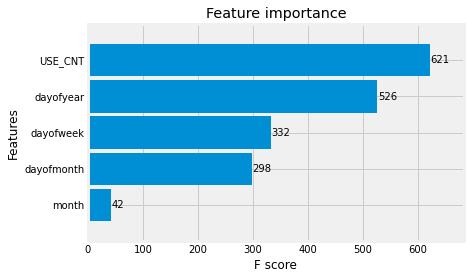

In [112]:
_ = plot_importance(reg2, height=0.9) # USE_CNT가 크게 유의미함

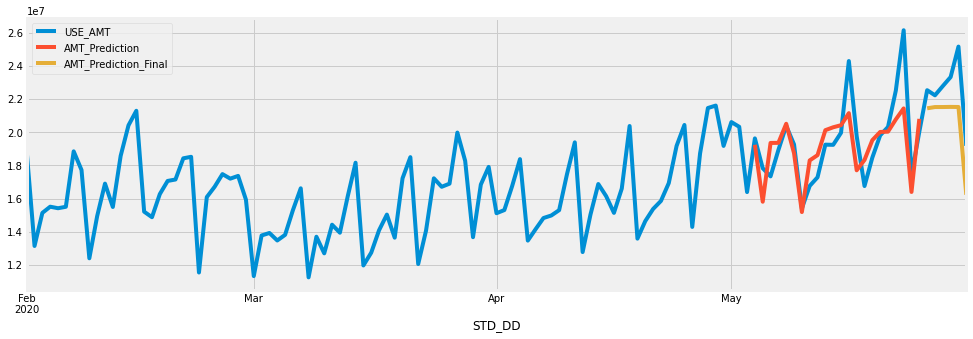

In [121]:
# 실제 test
df['date'] = df.index
X, y = create_features(df_test, label='USE_AMT')
X = X.join(df[['USE_CNT']], how='left')
pred = reg2.predict(X)

# val, test 각각의 예측값 시각화를 위한 데이터 생성
df_['AMT_Prediction'] = list(reg2.predict(X_test)) + list(pred)
df_val_ = df_[df_.index <= split_date2][['AMT_Prediction']]
df_test_ = df_[df_.index > split_date2][['AMT_Prediction']]\
            .rename(columns={'AMT_Prediction': 'AMT_Prediction_Final'})
df_ = df[['USE_AMT']]

# # 예측 결과
df_all = df_.join(df_val_, how='left').join(df_test_, how='left')
_ = df_all.plot(figsize=(15, 5))

In [123]:
# 오차가 줄어들었다.
mean_absolute_percentage_error(y_true=y, y_pred=reg2.predict(X))

8.54 %


### 2. 코로나 확진자 수 Feature 추가

In [88]:
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [89]:
covid_seoul = covid[covid.province == 'Seoul']
covid_seoul = covid_seoul.groupby('date').sum().reset_index()
covid = covid.groupby('date').sum().reset_index()

print('covid')
display(covid.head())
print('covid_seoul')
display(covid_seoul.head())

covid


,date,time,confirmed,released,deceased
0,2020-01-20,272,1,0,0
1,2020-01-21,272,1,0,0
2,2020-01-22,272,1,0,0
3,2020-01-23,272,1,0,0
4,2020-01-24,272,2,0,0


covid_seoul


,date,time,confirmed,released,deceased
0,2020-01-20,16,0,0,0
1,2020-01-21,16,0,0,0
2,2020-01-22,16,0,0,0
3,2020-01-23,16,0,0,0
4,2020-01-24,16,0,0,0


In [90]:
covid_seoul['date'] = covid_seoul.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))

### 전국, 서울 코로나 확진자
- 확진자 수(confirmed)
- 완치(released)
- 사망(deceased)

In [124]:
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-02-01']
covid_seoul = covid_seoul[covid_seoul.date < '2020-06-01'][covid_seoul.date >= '2020-02-01']

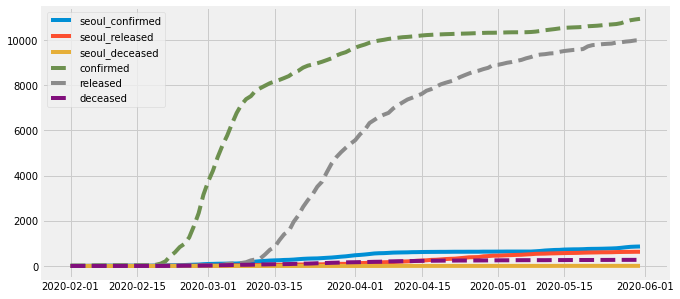

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(covid_seoul.date, covid_seoul.confirmed, label='seoul_confirmed')
plt.plot(covid_seoul.date, covid_seoul.released, label='seoul_released')
plt.plot(covid_seoul.date, covid_seoul.deceased, label='seoul_deceased')
plt.plot(covid.date, covid.confirmed, label='confirmed', ls="--")
plt.plot(covid.date, covid.released, label='released', ls="--")
plt.plot(covid.date, covid.deceased, label='deceased', ls="--")
plt.legend()
plt.show()

In [125]:
# 전국 covid features 추가
df = df2020.groupby('STD_DD')[['USE_CNT', 'USE_AMT']].sum()
df['date'] = df.index
df = pd.merge(covid, df.reset_index()).groupby('STD_DD').sum().drop('time', axis=1)

split_date = '2020-05-03'
split_date2 = '2020-05-25'

df_train = df[df.index <= split_date]
df_ = df[df.index > split_date] # test + val
df_val = df_[df_.index <= split_date2]
df_test = df_[df_.index > split_date2]

X_train_, y_train = create_features(df_train, label='USE_AMT')
X_test_, y_test = create_features(df_val, label='USE_AMT')
X_train = X_train_.join(df_train[['USE_CNT', 'confirmed', 'released', 'deceased']])
X_test = X_test_.join(df_val[['USE_CNT', 'confirmed', 'released', 'deceased']]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [126]:
reg3 = xgb.XGBRegressor(n_estimators=1000)
reg3.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # Change verbose to True if you want to see it train

[16:20:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

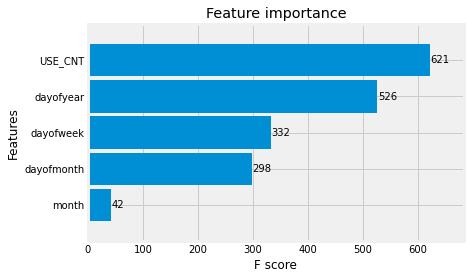

In [127]:
_ = plot_importance(reg3, height=0.9)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

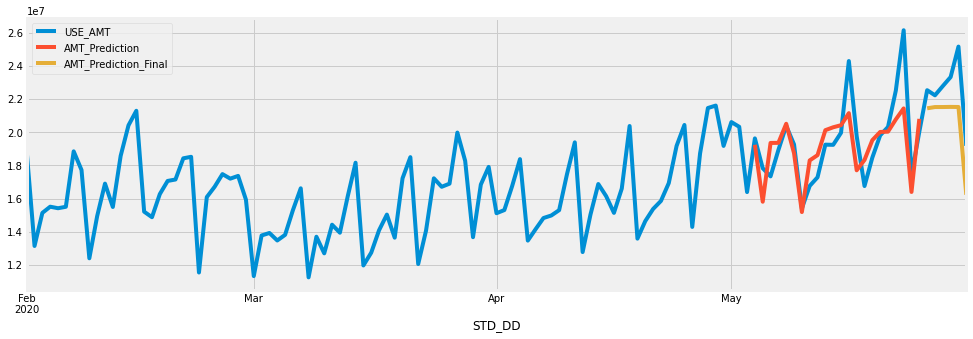

In [128]:
# 실제 test
df['date'] = df.index
X, y = create_features(df_test, label='USE_AMT')
X = X.join(df[['USE_CNT', 'confirmed', 'released', 'deceased']], how='left')
pred = reg3.predict(X)

# # val, test 각각의 예측값 시각화를 위한 데이터 생성
df_['AMT_Prediction'] = list(reg3.predict(X_test)) + list(pred)
df_val_ = df_[df_.index <= split_date2][['AMT_Prediction']]
df_test_ = df_[df_.index > split_date2][['AMT_Prediction']]\
            .rename(columns={'AMT_Prediction': 'AMT_Prediction_Final'})
df_ = df[['USE_AMT']]

# # 예측 결과
df_all = df_.join(df_val_, how='left').join(df_test_, how='left')
_ = df_all.plot(figsize=(15, 5))

In [129]:
mean_absolute_percentage_error(y_true=y, y_pred=reg3.predict(X))

8.54 %


#### 이어서 할 것
1. 코로나 변수 추가해도 똑같이 나오는 문제 해결
2. 시계열의 윈도우 개념 고려한 모델 개선